In [151]:
# import necessary libraries and set numpy seed
import pandas as pd
import numpy as np
import random
from collections import Counter
import math
import matplotlib.pyplot as plt
import copy
np.random.seed(1337)
random.seed(1337)

In [152]:
class TreeNode:
    def __init__(self, feature, branch=None):
        self.parent_branch_val = branch
        self.feature = feature
        self.children  = []

# create a treenode class
class DecisionTree:
    def __init__(self):
        self.feature = None
        self.children = []
    

In [153]:
# create a decision tree instance
id3_tree = DecisionTree()

In [154]:
# read the csv file
elections_clean = pd.read_csv('elections_clean.csv')
num_rows_elections = elections_clean.shape[0]
selected_features = elections_clean[[
    'Education',
    'Religion',
    'EthnicMale',
    'EthnicFemale',
    'Democrat'
]]
selected_features

,Education,Religion,EthnicMale,EthnicFemale,Democrat
0,highschool diploma only,Other Misc,BLACK_MALE_rate,BLACK_FEMALE_rate,0
1,highschool diploma only,Catholic,BLACK_MALE_rate,BLACK_FEMALE_rate,0
2,some college,Christian Generic,BLACK_MALE_rate,BLACK_FEMALE_rate,0
3,highschool diploma only,Catholic,BLACK_MALE_rate,BLACK_FEMALE_rate,0
4,some college,Catholic,BLACK_MALE_rate,BLACK_FEMALE_rate,0
...,...,...,...,...,...
3140,some college,Catholic,MULTI_MALE_rate,NATIVE_AMERICAN_FEMALE_rate,0
3141,bachelors or higher,Catholic,MULTI_MALE_rate,NATIVE_AMERICAN_FEMALE_rate,1
3142,highschool diploma only,Mormon,MULTI_MALE_rate,NATIVE_AMERICAN_FEMALE_rate,0
3143,some college,Christian Generic,MULTI_MALE_rate,NATIVE_AMERICAN_FEMALE_rate,0


In [155]:
# function to calculate entropy
def calculate_entropy(positives=0, negatives=0):
    total = positives+negatives
    p_over_p_plus_n = positives/total
    n_over_p_plus_n = negatives/total
    log_pover = None
    log_nover = None
    if negatives == 0:
        log_nover = 0
    if positives == 0:
        log_pover = 0
    if negatives != 0:
        log_nover = math.log(n_over_p_plus_n, 2)
    if positives != 0:
        log_pover = math.log(p_over_p_plus_n, 2)


    return -p_over_p_plus_n * log_pover - n_over_p_plus_n * log_nover

In [156]:
# function to calculate conditional entropy
def calculate_conditional_entropy(col_name, dframe):
    # find the number of different values (discrete or categorical)
    # store the values in an array and find conditional probability for each one
    unique_col_vals = dframe[col_name].unique()
    unique_col_counts = dframe[col_name].value_counts()

    all_conditional_entropies = []
    
    for col_val in unique_col_vals:

        # get all rows with the unique column value
        unique_col_val_df = dframe[dframe[col_name] == col_val]

        # count the number of democrats and non-democrats in those rows
        unique_col_demo_counts = unique_col_val_df['Democrat'].value_counts()
        
        # calculate the entropy
        unique_col_val_entropy = None
        if len(unique_col_demo_counts) == 2:
            unique_col_val_entropy = calculate_entropy(positives=unique_col_demo_counts[1], negatives=unique_col_demo_counts[0])
        else:
            continue

        # calculate conditional entropy for this column value
        con_entrop = (unique_col_counts[col_val]/num_rows_elections) * unique_col_val_entropy

        # add this value to the array of conditional entropies
        all_conditional_entropies.append(con_entrop)

    # sum all conditional entropies together, and return
    return np.sum(all_conditional_entropies)

In [157]:
# function to validate a row for the decision tree
def validate_row(row, tree_root):
    node = copy.deepcopy(tree_root)
    while node.feature != 0 and node.feature != 1:
        node_child_set = False
        for child in node.children: 
            if child.parent_branch_val == row[node.feature]:
                node = child
                node_child_set = True
        if not node_child_set:
            return False
    return node.feature == row['Democrat']

In [158]:
# function to calculate information gain
def calculate_information_gain(whole_set_entropy, specific_entropy):
    return whole_set_entropy - specific_entropy

In [159]:
# get the best feature for current subset of rows
def get_best_feature(dframe, col_title=None):
    max_info_gain = 0
    best_feature = None
    for col_name in dframe.columns:
        if col_name == 'Democrat':
            break
        col_cond_entropy = calculate_conditional_entropy(col_name, dframe)
        info_gain = calculate_information_gain(elections_clean_entropy, col_cond_entropy)
        if info_gain > max_info_gain:
            best_feature = col_name
            max_info_gain = info_gain

    return {
        'feature': best_feature,
        'info_gain': max_info_gain
    }

In [160]:
def build_decision_tree(dframe, col_title, cur_tree_node, most_recent_feature, most_recent_ig):

    for colval in dframe[col_title].unique():
        new_df = dframe.loc[dframe[col_title] == colval]

        # count the number of demo vs non-demo in the sub dataframe
        unique_col_demo_counts = new_df['Democrat'].value_counts()
        # unique_col_demo_counts = unique_col_val_df['Democrat'].shape[0]
        # print(col_val)
        # print(unique_col_demo_counts)
        # print(len(unique_col_demo_counts))
        # exit(0)
        # to access the values, use int, not string (super weird)
        # calculate the entropy
        # unique_col_val_entropy = None

        # recurse or create a leaf node depending on if there's a mix of demo and non-demo or only one type
        if len(unique_col_demo_counts) == 1:
            # if only 1 type of outcome, add the appropriate leaf node

            # get the only key of the unique_col_demo_counts
            leaf_value = unique_col_demo_counts.index.tolist()[0]

            # create a new treenode to append to current node's children array
            leaf = TreeNode(feature=leaf_value, branch=colval)

            # add the leaf to the tree
            cur_tree_node.children.append(leaf)
        else:
            # find the feature with the best info gain
            cur_best = get_best_feature(new_df, col_title=col_title)
            # print(unique_col_demo_counts)

            # print(f"current best feature: {cur_best['feature']}")
            # print(f"current max info: {cur_best['info_gain']}")
            # print(f"most recent feature: {most_recent_feature}")
            # print(f"most recent info gain: {most_recent_ig}")

            # can't split further
            if cur_best['feature'] == most_recent_feature and cur_best['info_gain'] == most_recent_ig:
                # just let the majority win
                leaf_value = unique_col_demo_counts.index.tolist()[0]

                # create a new treenode to append to current node's children array
                leaf = TreeNode(feature=leaf_value, branch=colval)
                
                # add the leaf to the tree
                cur_tree_node.children.append(leaf)

            else:
                # create a new treenode for the best feature
                new_node = TreeNode(feature=cur_best['feature'], branch=colval)

                # add the feature as a node to the tree
                cur_tree_node.children.append(new_node)

                # recurse on the newly created node to add to the tree
                build_decision_tree(new_df, cur_best['feature'], new_node, cur_best['feature'], cur_best['info_gain'])

                # unique_col_val_entropy = calculate_entropy(positives=unique_col_demo_counts[1], negatives=unique_col_demo_counts[0])
                # unique_col_val_entropy = 0
                # print('testing!!!')
                # exit(0)
                # continue

        # best_feature = get_best_feature(new_df)
        # if best_feature:
        #     pass

In [161]:
## calculate number of positives (1) and negatives (0) for the whole data set
vote_outcome_count = elections_clean['Democrat'].value_counts()
vote_outcome_total = sum(vote_outcome_count)
elections_clean_entropy = calculate_entropy(positives=vote_outcome_count[1], negatives=vote_outcome_count[0])

root_stump = None
max_info_gain = 0
i =0
root = get_best_feature(selected_features)

id3_tree.feature = root['feature']

# build the tree
build_decision_tree(selected_features, id3_tree.feature, id3_tree, id3_tree.feature, root['info_gain'])


In [162]:
# shuffle the rows
selected_shuffled = selected_features.sample(frac=1)
print(selected_shuffled)

# split the data set to 70-30
split_spot = int(0.7*len(selected_shuffled))

training = selected_shuffled[:split_spot]
validation = selected_shuffled[split_spot:]

print(len(training))
print(len(validation))

                    Education           Religion       EthnicMale  \
1089  highschool diploma only  Christian Generic  BLACK_MALE_rate   
471   highschool diploma only  Christian Generic  BLACK_MALE_rate   
2132             some college           Catholic  BLACK_MALE_rate   
1904             some college  Christian Generic  BLACK_MALE_rate   
1119  highschool diploma only           Catholic  BLACK_MALE_rate   
...                       ...                ...              ...   
2727  highschool diploma only  Christian Generic  BLACK_MALE_rate   
1497  highschool diploma only  Christian Generic  BLACK_MALE_rate   
1256             some college  Christian Generic  BLACK_MALE_rate   
860   highschool diploma only  Christian Generic  MULTI_MALE_rate   
189   highschool diploma only  Christian Generic  BLACK_MALE_rate   

           EthnicFemale  Democrat  
1089  BLACK_FEMALE_rate         0  
471   BLACK_FEMALE_rate         1  
2132  BLACK_FEMALE_rate         0  
1904  BLACK_FEMALE_rate    

In [163]:
# test create another tree with 70% of the data
training_tree = DecisionTree()
training_root = get_best_feature(training)
training_tree.feature = training_root['feature']
print(training_tree.feature)

# build_decision_tree(selected_features, id3_tree.root_value, id3_tree, id3_tree.root_value, root['info_gain'])


build_decision_tree(training, training_tree.feature, training_tree, training_tree.feature, training_root['info_gain'])

Education


In [164]:
# try out a value on the created test tree
print(validation.head())

                    Education           Religion                 EthnicMale  \
1483  highschool diploma only  Christian Generic            BLACK_MALE_rate   
1599  highschool diploma only  Christian Generic            MULTI_MALE_rate   
2475  highschool diploma only  Christian Generic            BLACK_MALE_rate   
2403      bachelors or higher  Christian Generic            MULTI_MALE_rate   
2151  highschool diploma only  Christian Generic  NATIVE_AMERICAN_MALE_rate   

                     EthnicFemale  Democrat  
1483            BLACK_FEMALE_rate         0  
1599  NATIVE_AMERICAN_FEMALE_rate         0  
2475            BLACK_FEMALE_rate         0  
2403  NATIVE_AMERICAN_FEMALE_rate         0  
2151  NATIVE_AMERICAN_FEMALE_rate         0  


In [165]:
correct = 0
wrong = 0
for index, row in validation.iterrows():
#     print(row['Religion'])
    guess = validate_row(row, training_tree)
    if guess:
        correct+=1
    else:
        wrong+=1
correct_rate = correct/(correct+wrong)
print(correct_rate)
print('over')

0.8601694915254238
over


# Training and Validation Errors

In [166]:
# validation error
print(1-correct_rate)

0.13983050847457623


In [167]:
# training error

# go through all rows of the training set and try to predict outcome using the created tree!
# since there was failed splitting, there will definitely be missclassifications
correct = 0
wrong = 0
for index, row in training.iterrows():
    guess = validate_row(row, training_tree)
    if guess:
        correct+=1
    else:
        wrong+=1
correct_rate = correct/(correct+wrong)
print(1-correct_rate)

0.11494775102226262


# max tree depth

In [168]:
def get_max_depth(node, max_depth, cur_depth=0):
    if cur_depth > max_depth:
        max_depth = cur_depth
#     print(cur_depth)
    if len(node.children) == 0:
        return max_depth
    else:
        for child in node.children:
            return get_max_depth(child, max_depth, cur_depth+1)
print(get_max_depth(training_tree, 0))

5


# repeated features

In [169]:
def count_repeated_features(node, feature_count):
    if len(node.children) == 0:
        pass
    else:
        for child in node.children:
            if child.feature != 0 and child.feature != 1:
                if child.feature in feature_count:
                    feature_count[child.feature] += 1
                else:
                    feature_count[child.feature] = 1
                count_repeated_features(child, feature_count)
                
feature_count = {training_tree.feature: 1}# initialize with root feature
count_repeated_features(training_tree, feature_count)
feature_count

{'Education': 34, 'EthnicMale': 7, 'Religion': 6, 'EthnicFemale': 22}

# scatter plot

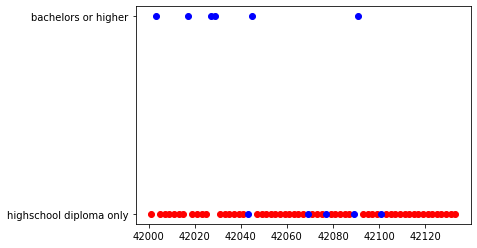

In [170]:
# use the original dataset for the scatterplot
# education for the y axis
# fips for the x axis

penn_rows = elections_clean[elections_clean['State'] == 42]

# get all rows with 0 outcome
non_democrat = penn_rows[penn_rows['Democrat'] == 0]
# get all rows with 1 outcome
only_democrat = penn_rows[penn_rows['Democrat'] == 1]
plt.scatter(non_democrat['fips'], non_democrat['Education'], color='red')
plt.scatter(only_democrat['fips'], only_democrat['Education'], color='blue')